In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

In [ ]:
# Import the data relative to the sentences positions and statistics 
# (sentence_statistic.csv).
print('\nImport sentence_statistic.csv\n')
upload = files.upload()

# Import the data relative to the suvbjectivity score of the sentences and the Type Token Ratio.
# (remaining_stat.csv).
print('\nImport remaining_stat.csv\n')
upload = files.upload()


Import sentence_statistic.csv




Import remaining_stat.csv



In [ ]:
# Import the Stab and Gurevych dataset for Argumentation Mining (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

# **Create the ann Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
Essay_ann_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(Essay_ann_dataset.index)):
  Essay_ann_dataset['span'][i]=Essay_ann_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Essay_ann_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T2,0,T2,MajorClaim,"(2154, 2231)",a more cooperative attitudes towards life is m...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."


# **IOB and word list**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Check the presence of the character | (information used later).
for essay in files_text:
  if not (essay.find("|") == -1):
      print("One found!")

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[sorted(list(Essay_ann_dataset.loc[Essay_ann_dataset['doc_id'] == i,['span','type']].values), key=lambda element: (element[0][0]) ) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay and the corresponding labels 
# ( argumentative section, premise or claim indicated through IOB).

Y_IOB=[]
X_essay_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  # Set boolean value next_token_is_argumentative to false.
  # (first section of each essay is never argumentative, it's the one containing the title).
  next_token_is_argumentative=False

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

    if next_token_is_argumentative:
      IOB+=['B']
      for token in range(len(seq)-1):
        IOB+=['I']  
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB.append(IOB)
  X_essay_word_list.append(essay_word_list)

In [ ]:
for i in range(80,120):
  print(X_essay_word_list[0][i]+" - "+Y_IOB[0][i])

i - O
firmly - O
believe - O
that - O
we - B
should - I
attach - I
more - I
importance - I
to - I
cooperation - I
during - I
primary - I
education - I
. - O
first - O
of - O
all - O
, - O
through - B
cooperation - I
, - I
children - I
can - I
learn - I
about - I
interpersonal - I
skills - I
which - I
are - I
significant - I
in - I
the - I
future - I
life - I
of - I
all - I
students - I
. - O
what - B


# **Find out sentences which contain argumentative section**

In [ ]:
sentence_list=[]

# Sentence associated to each word contained in the corpus.
# (to each word in a position is associated a sentence in the sentence list).
sentence_of_word=[]
num_total_sentences=0

for essay_id in range(len(X_essay_word_list)):
  sentence=""
  sentence_words_essay=[]

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    if not ( word=="." ):
      sentence+=word+" "
    sentence_words_essay.append(num_total_sentences)
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
            
      sentence=""
      num_total_sentences+=1

  if not sentence=="":
    sentence_list.append(sentence)
            
    sentence=""
    num_total_sentences+=1
    
  # Once the essay is over update the list of the sentences containing each word. 
  sentence_of_word.append(sentence_words_essay)

In [ ]:
# Create dataframe of the feature extracted until now over the sentences statistics
# and position in the text.

sentence_stat_dataframe=pd.read_csv('sentence_statistic.csv')

sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay
0,0,0,0,4,4,13,0.563686
1,0,1,1,4,4,23,0.997290
2,0,2,2,4,4,29,1.257453
3,0,3,3,4,4,19,0.823848
4,1,0,4,4,4,21,0.910569


In [ ]:
remaining_stat_dataframe=pd.read_csv('remaining_stat.csv')

sentence_stat_dataframe['subjectivity score']=remaining_stat_dataframe['subjectivity score'].tolist()
sentence_stat_dataframe['type token ratio']=remaining_stat_dataframe['type token ratio'].tolist()

sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay,subjectivity score,type token ratio
0,0,0,0,4,4,13,0.563686,0.99925,100.000000
1,0,1,1,4,4,23,0.997290,0.00466,76.923077
2,0,2,2,4,4,29,1.257453,0.59203,78.125000
3,0,3,3,4,4,19,0.823848,0.02907,100.000000
4,1,0,4,4,4,21,0.910569,0.00154,86.956522


In [ ]:
# Create the sequences of statistic of the sentences for each word.
sentence_word_stat=[]

for essay_sentence_of_word_list in sentence_of_word:
  sentence_word_essay=[]
  for word_sentence_id in essay_sentence_of_word_list:
    sentence_word_essay.append(sentence_stat_dataframe.iloc[word_sentence_id].to_list())
  sentence_word_stat.append(sentence_word_essay)

In [ ]:
# (Differences between values reported as length of the sentence and actual number
# of words due to the fact that puntation isn't counted in the sentence length).
sentence_word_stat[0][10:15]

[[0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0,
  1.0,
  1.0,
  4.0,
  4.0,
  23.0,
  0.997289972899729,
  0.00466,
  76.92307692307693]]

# **POS tags**

In [ ]:
# Separate each essay in the list of POS TAG that compones them.
POS_essay_list=[nltk.pos_tag(essay_word_sequence) for essay_word_sequence in X_essay_word_list]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_text_list(POS_list: list)->list:
  POS_all_text_list=[]
  for POS_list in POS_list:
    POS_single_text_list=[]
    for word, tag in POS_list:
      POS_single_text_list.append(tag)
    POS_all_text_list.append(POS_single_text_list)    

  return POS_all_text_list

In [ ]:
X_essay_POS_list=get_POS_text_list(POS_essay_list)

In [ ]:
X_essay_POS_list[0][0:10]

['PRP', 'VBZ', 'RB', 'VBD', 'IN', 'NN', 'MD', 'RB', 'VB', 'DT']

# **Word2vec and one-hot-encoding**

In [ ]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model.
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# buld word2vec model with the POS vocabulary of the essays in the dataset.
word2vec_sentences=[]

for text in X_essay_POS_list:
  word2vec_sentences.append(text)

word2vec_model_POS =  Word2Vec(sentences=word2vec_sentences, size=5, min_count=1)

In [ ]:
# Get the maximum lenght of the texts of the essays.

text_len = [len(text) for text in X_essay_word_list]
MAX_LEN = max(text_len)
print("Max lenght of the texts: {}".format(MAX_LEN))

Max lenght of the texts: 550


In [ ]:
# Add padd to the sequences of sentences stats.
# All the documents must have sequences of the same lenght.

padd_array_sentence_stat=[-1. for i in range(sentence_stat_dataframe.shape[1])]

for i in range(len(sentence_word_stat)):
  for j in range(MAX_LEN-text_len[i]):
    sentence_word_stat[i].insert(0,padd_array_sentence_stat)

In [ ]:
# Transform the statistic data into a 3d array of shape (number_of_essay x max_words_per_essay x number_statistic).
X_stat=np.array(sentence_word_stat)

X_stat.shape

(402, 550, 9)

In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_essay_word_list)
X = text_tokenizer.texts_to_sequences(X_essay_word_list)
X = pad_sequences(X, maxlen=MAX_LEN, padding="pre")

POS_tokenizer = Tokenizer()
POS_tokenizer.fit_on_texts(X_essay_POS_list)
X_POS = POS_tokenizer.texts_to_sequences(X_essay_POS_list)
X_POS = pad_sequences(X_POS, maxlen=MAX_LEN, padding="pre")

IOB_tokenizer = Tokenizer()
IOB_tokenizer.fit_on_texts(Y_IOB)
Y = IOB_tokenizer.texts_to_sequences(Y_IOB)
Y = pad_sequences(Y, maxlen=MAX_LEN, padding="pre")

In [ ]:
X[0][100:250]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   14,    9,
        153,  767,   10,  407,   18,  730,  942,    3,  189,    5,  478,
          2,    7,  179,    4, 1033,    7,    3,  407,    1,  296,  862,
          4,  244,   15,  373,    6, 1034,    1,    6,   20,    8,  175,
          1,    3,  366,   88, 4573,    2,   61,    1,   56,   40,  680,
          3,  261,    5,  407,   27,  831,    1,  105,   40,   12,  554,
         65,    9,   22,    3,  366,   88,    1,   45,    3,  189,    5,
         51,  513,   41,  366,   38,    2,   32,   26,  197,    5,  161,
          1,   17,  863,   75,   10,   40,   33, 2434,   24,  437,    4,
        831,  257,  943,   74,    2,   81,    5,   48,    1,  198,  831,
          1,   53,   18,   87,   65, 2819,  139], d

In [ ]:
X_POS[0][100:250]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 13, 14,  8, 20,  2,  1, 15,  8,  6,
        5,  1,  2,  1,  9,  2,  1, 11,  6,  2,  5,  1,  7,  3, 10, 11,  6,
       17,  3, 12,  1,  7, 12,  2,  5,  1,  7,  5,  4,  1,  3,  9,  8,  7,
       22, 13, 10,  5,  1,  2,  1, 12,  1,  7, 25, 13, 10, 18,  2, 14,  8,
        5,  4,  1,  7, 12,  5,  1,  2,  5,  1, 26,  4,  1,  9,  2,  5,  1,
        2,  1,  7,  1,  8, 10,  2, 13, 15,  6, 19,  1, 11,  1,  2,  4,  1,
        9,  4,  2,  5,  7,  2,  1,  7,  3, 15,  6,  2,  4,  3],
      dtype=int32)

In [ ]:
Y[0][100:250]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300.
EMBEDDING_SIZE  = 300
EMBEDDING_SIZE_POS  = 5

# Size of the vocabulary used.
VOCABULARY_SIZE = len(text_tokenizer.word_index) + 1
VOCABULARY_SIZE_POS = len(POS_tokenizer.word_index) + 1

# Create an empty embedding matix.
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
embedding_weights_POS = np.zeros((VOCABULARY_SIZE_POS, EMBEDDING_SIZE_POS))

# Create a word to index dictionary mapping.
word2id = text_tokenizer.word_index
word2id_POS = POS_tokenizer.word_index

# Copy vectors from word2vec model to the words present in corpus.
print("words:")
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

print("POS:")
for word, index in word2id_POS.items():
    try:
        embedding_weights_POS[index, :] = word2vec_model_POS[word]
    except KeyError:
        print(word)        

words:
,
.
to
of
and
a
's
'
;
’
``
''
?
:
part-time
e-mail
face-to-face
centre
-
his/her
well-being
(
)
co-operative
co-operation
20
high-tech
distance-learning
!
co-worker
15
co-workers
30
50
travelling
21st
toefl
learnt
he/she
well-known
10
judgement
long-term
favour
above-mentioned
group-studying
high-quality
co-tenant
time-consuming
labour
analysing
eco-friendly
long-time
short-sighted
“
16
state-of-the-art
–
behaviour
so-called
programmes
organisations
ibt
long-distance
face-to
up-to-date
20th
self-control
self-study
theatre
dish-washing
‘
ever-increasing
long-lasting
75
2008
well-prepared
hard-working
organisation
online-teaching
e-mails
cut-throat
self-improvement
co-education
89
non-profit
40
well-rounded
cutting-edge
whole-heartedly
e-books
brunei
fifty-five
2003
multiple-choice
well-trained
well-educated
19th
--
100
well-informed
'a
open-minded
environmentally-friendly
well-paid
universtiy
devoiding
white-collar
non-academic
team-working
second-hand
time-saving
him/her
penalt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

# **RNN**

In [ ]:
# Create and train recurrent models.

# Bidirectional LSTM model.

def train_BLSTM(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN,))

  model = Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN, weights= [embedding_weights], trainable=True)(input)
  model = Bidirectional(LSTM(64, return_sequences=True))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Model for the statitistic values manually extracted.

def train_statistic_model(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the model.
  input = Input(shape=(MAX_LEN,sentence_stat_dataframe.shape[1]))

  model = TimeDistributed(Dense(16, activation='relu'))(input)
  model = Dropout(0.1)(model)

  return model,input

In [ ]:
# Model for the statitistic values manually extracted.

def train_POS_model(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the model.
  input = Input(shape=(MAX_LEN,))

  model = Embedding(input_dim=VOCABULARY_SIZE_POS, output_dim=EMBEDDING_SIZE_POS, input_length=MAX_LEN, weights= [embedding_weights_POS], trainable=True)(input)
  model = Bidirectional(LSTM(8, return_sequences=True))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Multimodal model.

def train_MultiModal(X_train:np.ndarray, X_stat:np.ndarray, X_POS:np.ndarray, Y_train:np.ndarray)->Model:

  num_label = Y_train.shape[2]

  # Create the BLSTM model.
  model_BLSTM,input_BLSTM=train_BLSTM(X_train, Y_train)
  # Create the others model.
  model_statistic,input_statistic=train_statistic_model(X_stat,Y_train)
  model_POS,input_POS=train_POS_model(X_POS,Y_train)

  # Concatenate togheter the two previous NN.
  concatenation_layer = Concatenate()([model_BLSTM,model_statistic,model_POS])

  output = TimeDistributed(Dense(num_label, activation='softmax'))(concatenation_layer)

  final_model=Model([input_BLSTM,input_statistic,input_POS],output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_train,X_stat,X_POS], Y_train, batch_size=64, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=4),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

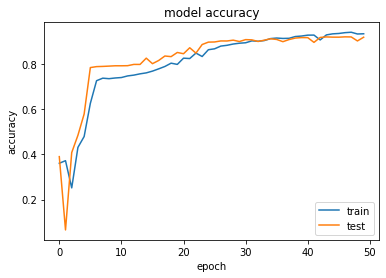

In [ ]:
target_names=['X','I','O','B']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2,3 where 0 indicate the absence of words).
categorical_Y = to_categorical(Y)

X_train, X_test = X[train_set], X[test_set]
X_statistic_train,X_statistic_test=X_stat[train_set],X_stat[test_set]
X_POS_train,X_POS_test=X_POS[train_set],X_POS[test_set]
Y_train, Y_test = categorical_Y[train_set], categorical_Y[test_set]

# Train the model.
model=train_MultiModal(X_train, X_statistic_train,X_POS,Y_train)

prediction=model.predict([X_test,X_statistic_test,X_POS_test])
for i in range(len(Y_test)):
  y_pred+=np.argmax(prediction[i], axis = 1).tolist()
  y_true+=np.argmax(Y_test[i].tolist(), axis = 1).tolist()

In [ ]:
# Print the classification report of the result of the models created.
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           X       1.00      1.00      1.00     11860
           I       0.84      0.96      0.90     13803
           O       0.88      0.73      0.80      6987
           B       0.57      0.07      0.13       900

    accuracy                           0.90     33550
   macro avg       0.82      0.69      0.71     33550
weighted avg       0.90      0.90      0.89     33550



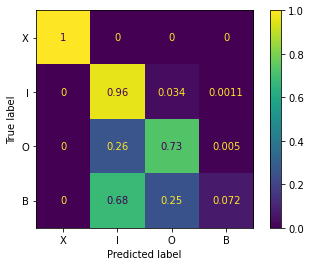

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

# **Remove padding from results**

In [ ]:
  y_true_nonzero=[]
  y_pred_nonzero=[]

  # Transform probabilities predicted in the most probable value (0 or 1).
  y_true_temp=y_true
  y_pred_temp=y_pred
  for i in range(len(y_true_temp)):
      if not y_true_temp[i]==0:
        if y_pred_temp[i]==0:
          y_pred_temp[i]=2
        y_true_nonzero+=[y_true_temp[i]]
        y_pred_nonzero+=[y_pred_temp[i]]

  # Print the classification report of the result of the models created.
  print(classification_report(y_true_nonzero, y_pred_nonzero, target_names=['I','O','B'], zero_division=0))

              precision    recall  f1-score   support

           I       0.84      0.96      0.90     13803
           O       0.88      0.73      0.80      6987
           B       0.57      0.07      0.13       900

    accuracy                           0.85     21690
   macro avg       0.76      0.59      0.61     21690
weighted avg       0.84      0.85      0.84     21690

